In [1]:
# 以下が必要
# conda install pandas-profiling
# conda install category_encoders -y
# conda install graphviz -y
# conda install python-graphviz -y

In [2]:
%ls

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は CA67-50C9 です

 C:\Users\tsk_sato\Documents\DataAnalysisProjects のディレクトリ

2019/03/20  17:41    <DIR>          .
2019/03/20  17:41    <DIR>          ..
2018/08/30  15:52                20 .gitignore
2019/03/20  14:38    <DIR>          .ipynb_checkpoints
2018/08/24  13:25             2,141 anomaly_detection_method_evaluation.py
2018/12/20  10:51    <DIR>          data
2019/03/20  17:09             3,555 Digraph.gv
2019/03/20  17:09            29,166 Digraph.gv.pdf
2019/03/18  17:40             2,607 EDA_GMS.ipynb
2019/03/18  17:49            23,945 folium_uktaxi.ipynb
2018/08/23  15:12             5,577 GMM_SkillCraft1.ipynb
2018/08/23  15:13             5,697 KDE_SkillCraft1.ipynb
2019/03/18  17:49            13,765 keras_001.ipynb
2018/08/30  15:49             9,149 LOF_SkillCraft1.ipynb
2019/03/19  16:35            31,153 MTS_SkillCraft1.ipynb
2019/03/18  17:49    <DIR>          output
2018/09/03  11:16                66 README.md
2019/03/2

In [3]:
import warnings
warnings.filterwarnings("ignore")
import category_encoders as ce
import graphviz
import itertools
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pdp
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, train_test_split
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 300)

# データ読み込み

In [4]:
%time
file_name = "../python_codes/data/mushroom.csv"
df = pd.read_csv(file_name, header=None, index_col=None, sep=',')

Wall time: 0 ns


In [5]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m


In [6]:
# レポート作成
pdp.ProfileReport(df)

Number of variables,23
Number of observations,8124
Total Missing (%),0.0%
Total size in memory,1.4 MiB
Average record size in memory,184.0 B
Numeric,0
Categorical,22
Date,0
Text (Unique),0
Rejected,1
Distinct count,2


In [7]:
# 行数列数
df.shape

(8124, 23)

In [8]:
# カラムの型
df.dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
15    object
16    object
17    object
18    object
19    object
20    object
21    object
22    object
dtype: object

In [9]:
# 基本統計量
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [10]:
# 欠損値確認
df.isnull().any(axis=0)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
dtype: bool

In [11]:
# 欠損個数確認
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
dtype: int64

In [12]:
# '?'を含む行数を確認
stats = []
for col in df.columns:
    stats.append(
        (col,                                                                      # 列名
         df[col].nunique(),                                                        # ユニークな値をカウント
         (df[col]=='?').sum() * 100 / df.shape[0]                                  # 欠損値の割合
            if not np.issubdtype(df[col].dtype, np.number) else 0.0,              # 数値型か確認
         df[col].value_counts(normalize=True, dropna=False).values[0] * 100,      # 最大派閥に属するカテゴリ割合 
         df[col].dtype)                                                           # 型
    )
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
11,11,5,30.526834,46.479567,object
12,12,4,0.000000,63.712457,object
21,21,6,0.000000,49.729197,object
20,20,9,0.000000,29.394387,object
19,19,5,0.000000,48.842935,object
18,18,3,0.000000,92.171344,object
17,17,4,0.000000,97.538159,object
16,16,1,0.000000,100.000000,object
15,15,9,0.000000,53.963565,object
14,14,9,0.000000,54.948301,object


In [13]:
df[df[11]=='?'].head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
3984,e,x,y,b,t,n,f,c,b,e,e,?,s,s,e,w,p,w,t,e,w,c,w
4023,p,x,y,e,f,y,f,c,n,b,t,?,k,s,w,w,p,w,o,e,w,v,p
4076,e,f,y,u,f,n,f,c,n,h,e,?,s,f,w,w,p,w,o,f,h,y,d


- 列名16が定数なので除去対称
- 列名11が欠損値?を含むので対応が必要
- 列名6, 17, 18が最大派閥に含まれるカテゴリが9割以上で、除去対称になるかも

In [14]:
# 不均衡カラムの除去
good_cols = list(df.columns)
for col in df.columns:
    rate = df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
df = df[good_cols]

In [15]:
# 欠損値の補完
#----------------------------------------------#
# ここでは欠損値 ? もひとつのカテゴリとして扱うことに
#----------------------------------------------#

# とりあえず平均値で補完
# mean_Age = df[(df['Age']!='?')]['Age'].values.astype('float').mean()
# mean_TotalHours = df[(df['TotalHours']!='?')]['TotalHours'].values.astype('float').mean()
# mean_HoursPerWeek = df[(df['HoursPerWeek']!='?')]['HoursPerWeek'].values.astype('float').mean()
# 平均値を代入
# df.loc[df['Age']=='?', 'Age'] = mean_Age
# df.loc[df['TotalHours']=='?', 'TotalHours'] = mean_TotalHours
# df.loc[df['HoursPerWeek']=='?', 'HoursPerWeek'] = mean_HoursPerWeek

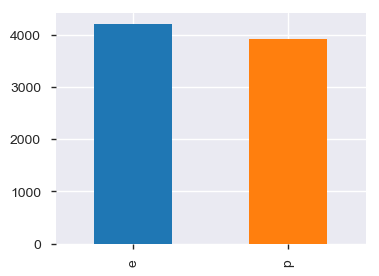

In [16]:
# ターゲットカラム集計
plt.figure(figsize=(4,3))
df[0].value_counts().plot.bar()
plt.show()

# 学習

In [17]:
target_col = 0
delete_col = [target_col]
y = df[target_col]
X = df.drop(delete_col, axis=1)

In [18]:
pd.get_dummies(y).head()

,e,p
0,0,1
1,1,0
2,1,0
3,0,1
4,1,0


In [19]:
# e=1, p=0 と変換
y = pd.get_dummies(y)['e']

In [20]:
# One-Hot encoding
ce_ohe = ce.one_hot.OneHotEncoder(drop_invariant=True, handle_unknown="ignore")
X = ce_ohe.fit_transform(X)

In [21]:
# 訓練データと評価データを生成
X_train, X_test, y_train, y_test = train_test_split(X, y)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [22]:
# パラメータ設定
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 8,
        'learning_rate': 0.1,
        'num_leaves': 32,
        'min_data_in_leaf': 3,
        'num_iteration': 200,
        'verbose': -1,
        'seed': 40002
}

In [23]:
# 学習
gbm = lgb.train(params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    early_stopping_rounds=20
)

[1]	valid_0's multi_logloss: 0.490474
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 0.430289
[3]	valid_0's multi_logloss: 0.379164
[4]	valid_0's multi_logloss: 0.33532
[5]	valid_0's multi_logloss: 0.297433
[6]	valid_0's multi_logloss: 0.264487
[7]	valid_0's multi_logloss: 0.235689
[8]	valid_0's multi_logloss: 0.210408
[9]	valid_0's multi_logloss: 0.188131
[10]	valid_0's multi_logloss: 0.168439
[11]	valid_0's multi_logloss: 0.150986
[12]	valid_0's multi_logloss: 0.135481
[13]	valid_0's multi_logloss: 0.121677
[14]	valid_0's multi_logloss: 0.109366
[15]	valid_0's multi_logloss: 0.0983704
[16]	valid_0's multi_logloss: 0.0885349
[17]	valid_0's multi_logloss: 0.0797268
[18]	valid_0's multi_logloss: 0.0718302
[19]	valid_0's multi_logloss: 0.064744
[20]	valid_0's multi_logloss: 0.0583796
[21]	valid_0's multi_logloss: 0.0526593
[22]	valid_0's multi_logloss: 0.0475142
[23]	valid_0's multi_logloss: 0.0428839
[24]	valid_0's multi_logloss: 0.0387144
[25

# 評価

In [24]:
# 予測
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

In [25]:
# 精度
accuracy_score(y_test, y_pred_max)

1.0

In [26]:
# 評価レポート
target_names = ['p', 'e']
print(classification_report(y_test, y_pred_max, target_names=target_names))

              precision    recall  f1-score   support

           p       1.00      1.00      1.00       959
           e       1.00      1.00      1.00      1072

   micro avg       1.00      1.00      1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [27]:
# 変数重要度
importance = pd.DataFrame(gbm.feature_importance(), index=gbm.feature_name(), columns=['importance'])
display(importance)

,importance
1_1,368
1_2,145
1_3,24
1_4,178
1_5,78
1_6,0
2_1,138
2_2,107
2_3,54
2_4,0


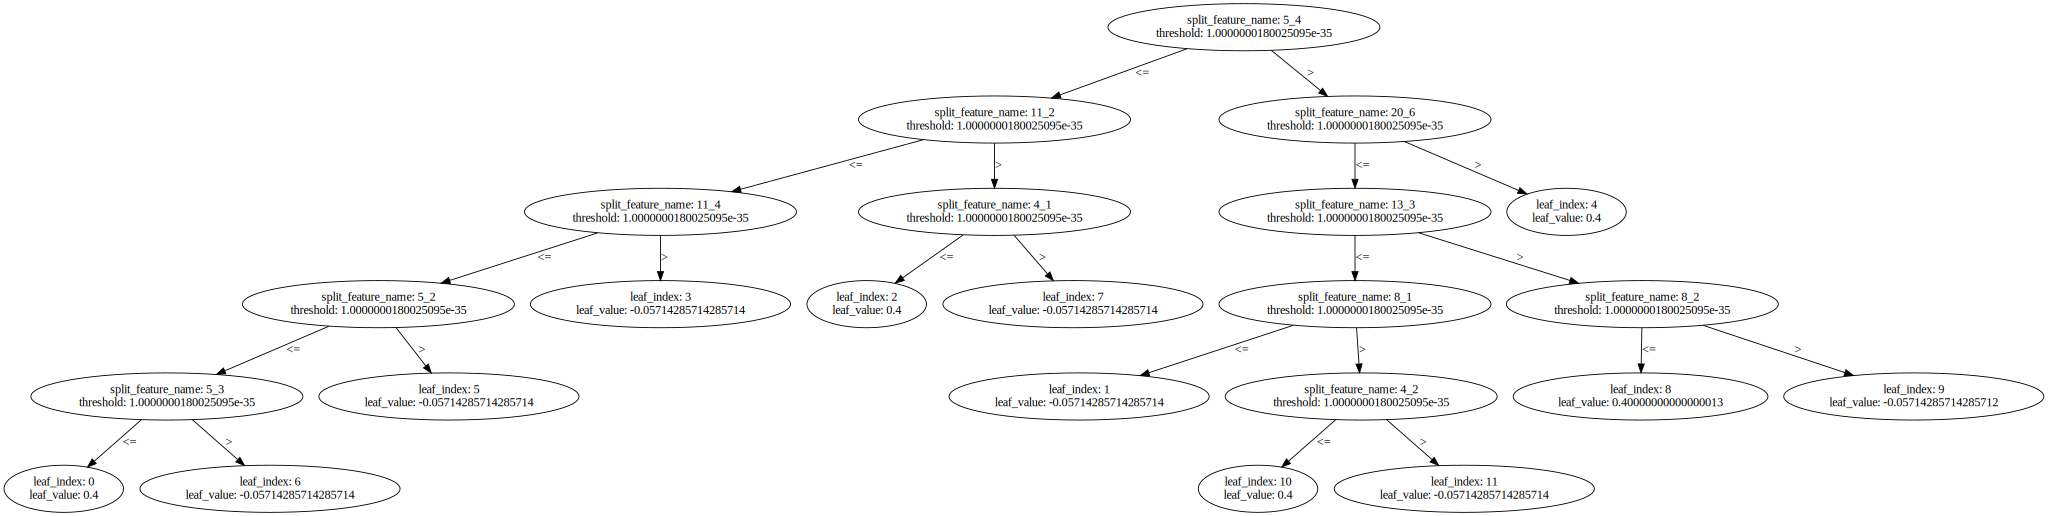

In [28]:
# 木の可視化 ... うまく描画するときとされないときがあるが ...
# lightgbm のいろいろな乱数シード依存な気がする
lgb.create_tree_digraph(gbm)
# graph.render(view=True)  # PDF に出力

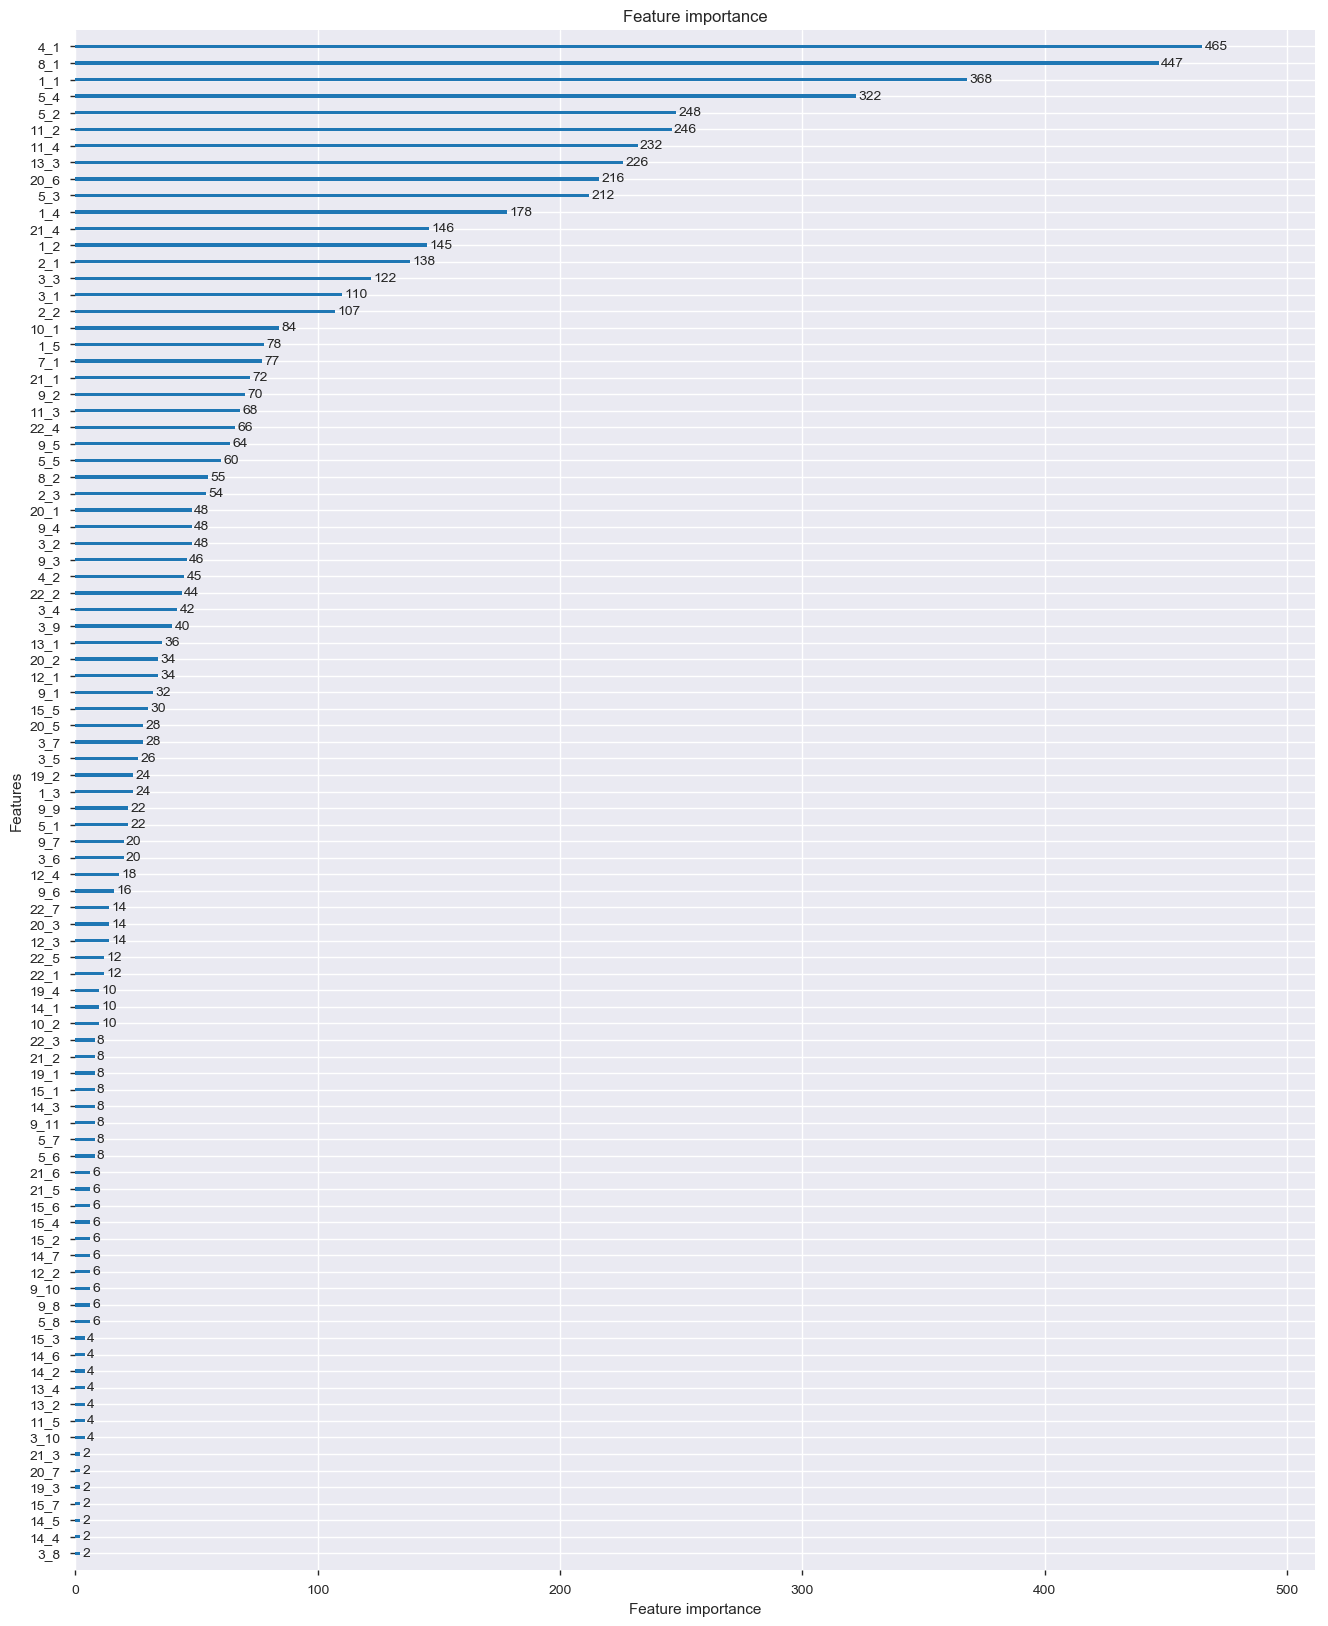

In [29]:
lgb.plot_importance(gbm, figsize=(16,20))
plt.show()